# EDA 
**How to use**
1. Open this file in Jupyter / JupyterLab / Colab.  
2. Run cells *top to bottom* (Kernel: Python 3.10+ recommended).  
3. When running data fetch cells you'll need internet for `yfinance`

This section sets up the working environment and imports all required Python libraries for data analysis, visualization, and validation.

I use stable, well-supported libraries like **pandas**, **numpy**, and **matplotlib** for data manipulation and plotting. For financial data retrieval and alignment, I use **yfinance** and **pandas_market_calendars** to integrate market trading calendars directly into the preprocessing pipeline.  
In addition, I configure global plotting and display options to make charts more consistent and the notebook output cleaner and easier to interpret.

> **Why**: A strong and consistent setup ensures smooth downstream execution and keeps the focus on analysis instead of troubleshooting environment issues.


In [20]:
# 1. Setup & Imports
import os                               # File system operations
import pandas as pd                     # Data handling
import numpy as np                      # Numerical operations
import matplotlib.pyplot as plt         # Plotting
import seaborn as sns                   # Advanced visualization
import yfinance as yf                   # Fetch stock data
import pandas_market_calendars as mcal  # Market trading calendar
from datetime import datetime
from scipy import stats                 # Z-score / statistical functions
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")


# Display & Plotting settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

# display inline (Jupyter)
%matplotlib inline

print("Packages imported. Matplotlib inline ready.")

Packages imported. Matplotlib inline ready.


## 2) Configuration
This configuration cell defines all key parameters used throughout the notebook, including:

- Target stock tickers (e.g., AAPL, MSFT, TSLA)
- Start and end date ranges for analysis
- Directory paths for saving cleaned and processed data

By centralizing these variables, I can easily modify the dataset or analysis scope without making changes in multiple places in the code. This makes the workflow cleaner, more maintainable, and easier to reproduce.

> **Why**: Centralized configuration improves maintainability, reproducibility, and flexibility in scaling the analysis.


In [21]:
# 2) Configuration (edit if needed)
CONFIG = {
    "tickers": ["AAPL", "MSFT", "GOOGL", "JPM", "TSLA"],
    "start_date": "2022-01-01",
    "end_date": "2025-01-01",
    "backup_path": "data/backup_stocks.csv",
    "output_long": "data/cleaned_stock_data_long.csv",
    "output_wide": "data/cleaned_stock_data_wide.csv",
}
CONFIG

{'tickers': ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'TSLA'],
 'start_date': '2022-01-01',
 'end_date': '2025-01-01',
 'backup_path': 'data/backup_stocks.csv',
 'output_long': 'data/cleaned_stock_data_long.csv',
 'output_wide': 'data/cleaned_stock_data_wide.csv'}

## 3) Data Acquisition
This section focuses on **retrieving historical stock price data**.  

The main function, `fetch_stock_data()`, uses **yfinance** to download OHLCV (Open, High, Low, Close, Volume) data efficiently for multiple tickers in a single API call. I also implement a fallback to local CSV files, so the notebook remains functional even if the API fails or there is no internet access.  

The acquisition process includes:
- Validating ticker list and date ranges
- Handling network errors and invalid symbols gracefully
- Returning a multi-indexed DataFrame (Ticker × Date)

> **Why**: Reliable data acquisition is critical. Using both live API calls and local fallbacks ensures robustness and reduces the risk of broken pipelines during demos or production runs.


In [22]:
def fetch_stock_data(tickers, start, end, backup_path):
    """Fetch historical stock data from yfinance (multi-ticker) with CSV fallback."""
    try:
        # Validate input
        if not tickers:
            raise ValueError("No tickers provided")

        # Attempt to fetch from yfinance
        data = yf.download(
            tickers,
            start=start,
            end=end,
            group_by="ticker",
            auto_adjust=True,
            progress=False
        )

        if data.empty:
            raise ValueError("Empty response from yfinance")

        print(f"Data fetched for {len(tickers) if isinstance(tickers, list) else 1} "
              f"ticker(s): {start} → {end}")
        return data

    except Exception as e:
        # Fallback to backup CSV if API call fails
        print(f"yfinance failed: {e}. Loading backup CSV: {backup_path}")
        return pd.read_csv(backup_path, parse_dates=['Date'])


# Example usage (uncomment to run in notebook)
raw_data = fetch_stock_data(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'], CONFIG['backup_path'])
raw_data.head()

Data fetched for 5 ticker(s): 2022-01-01 → 2025-01-01


Ticker            MSFT                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  325.086250  327.655138  319.686719  324.504608  28865100   
2022-01-04  324.582127  324.940827  316.138715  318.940277  32674300   
2022-01-05  315.886673  316.090267  306.309087  306.696838  40054300   
2022-01-06  303.565739  308.945893  301.956541  304.273407  39646100   
2022-01-07  304.535116  306.813198  300.599379  304.428497  32720000   

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  174.345068  179.296107  174.227425  178.443146  104487900   
2022-01-04  179.050979  179.354901  175.609755  176.178391   99310400   
2022-01-05  176.090189  176.639212  171.217584  171.492096   94537600   
2022-01-06  169.315582  171.864636  168.276357  168.629303   96904000   
2022-01-07  169.501851  170.727354  167.678301  168.795959   86709100   

Ticker            TSLA                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  382.583344  400.356659  378.679993  399.926666  103931400   
2022-01-04  396.516663  402.666656  374.350006  383.196655  100248300   
2022-01-05  382.216675  390.113342  360.336670  362.706665   80119800   
2022-01-06  359.000000  362.666656  340.166656  354.899994   90336600   
2022-01-07  360.123322  360.309998  336.666656  342.320007   84164700   

Ticker           GOOGL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.061363  144.851916  142.728561  143.998306  28646000   
2022-01-04  144.400065  145.481610  142.732080  143.410400  28400000   
2022-01-05  143.430756  143.509710  136.744874  136.831268  54618000   
2022-01-06  136.060093  138.981442  135.623104  136.803955  37348000   
2022-01-07  137.199210  137.500143  134.836508  136.078445  29760000   

Ticker             JPM                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2022-01-03  143.926634  146.429548  143.611513  145.583237  13120900  
2022-01-04  147.933116  151.777527  147.861088  151.102280  20195800  
2022-01-05  151.998939  152.488025  148.294509  148.339798  17539400  
2022-01-06  151.174730  151.591356  148.421315  149.915771  14047500  
2022-01-07  150.051647  151.736298  149.499154  151.401184  13913300

## 4) Cleaning functions
This section standardizes and validates the raw data to make it ready for downstream analysis. The cleaning steps ensure the dataset is accurate, consistent, and analytically sound.

**Key cleaning steps:**
- Normalize and convert date columns to timezone-naive
- Sort values chronologically
- Drop rows with excessive missing values
- Forward and backward fill remaining gaps
- Remove duplicate entries, preserving first occurrence
- Enforce numeric data types and validate non-negative values

The functions are modular — `clean_stock_data` processes a single ticker, while `clean_all_tickers` applies the steps in batch for multiple tickers.  

> **Why**: Clean, validated data prevents downstream analytical errors, improves reliability, and ensures any anomalies detected later reflect actual market behavior rather than data quality issues.



In [23]:
# 4. Data Cleaning
def clean_stock_data(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """
    Clean stock data for a single ticker.
    
    Steps:
        - Ensure required columns are present
        - Normalize and sort by date
        - Handle missing values (drop if >50%, else forward/backward fill)
        - Drop duplicates and enforce numeric dtypes
        - Validate constraints (non-negative prices, volumes and valid dates)
    """
    df = df.copy().reset_index()
    df["Ticker"] = ticker

    # Validate inputs and check required columns
    required_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' for {ticker}")

    if df.empty:
        raise ValueError(f"No data available for {ticker}")

    # Normalize and sort dates
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df.sort_values("Date", inplace=True)

    # Handle missing values (drop if >50% columns missing, else fill)
    core_cols = ["Open", "High", "Low", "Close", "Volume"]
    missing_pct = df[core_cols].isnull().mean(axis=1)
    df = df[missing_pct < 0.5] # Drop rows with excessive missing values

    # Fill remaining missing values using forward/backward fill
    df = df.ffill().bfill() 

    # Drop duplicate dates
    df.drop_duplicates(subset=["Date"], inplace=True)

    # Ensure numeric types
    for col in core_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Validation: no negative values
    if (df[["Open", "High", "Low", "Close"]] < 0).any().any():
        raise ValueError(f"Negative prices detected for {ticker}")
    if (df["Volume"] < 0).any():
        raise ValueError(f"Negative volumes detected for {ticker}")

    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)

    return df


In [24]:
def clean_all_tickers(raw_data: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    """
    Clean stock data for multiple tickers and combine into a single DataFrame.
    """
    cleaned_list = []

    for t in tickers:
        try:
            temp = raw_data[t].reset_index()
            cleaned = clean_stock_data(temp, t)
            cleaned_list.append(cleaned)
            print(f"{t} cleaned successfully ({len(cleaned)} rows).")
        except Exception as e:
            print(f"Error processing {t}: {e}")

    combined = pd.concat(cleaned_list, ignore_index=True)

    # Drop extra 'index' column if present
    if "index" in combined.columns:
        combined.drop(columns=["index"], inplace=True)

    return combined

In [25]:
# Example usage (uncomment to run after fetching data)
cleaned_data = clean_all_tickers(raw_data, CONFIG["tickers"])
print(f"Final cleaned dataset shape: {cleaned_data.shape}")
cleaned_data.head()

AAPL cleaned successfully (753 rows).
MSFT cleaned successfully (753 rows).
GOOGL cleaned successfully (753 rows).
JPM cleaned successfully (753 rows).
TSLA cleaned successfully (753 rows).
Final cleaned dataset shape: (3765, 7)


Price,Date,Open,High,Low,Close,Volume,Ticker
0,2022-01-03,174.345068,179.296107,174.227425,178.443146,104487900,AAPL
1,2022-01-04,179.050979,179.354901,175.609755,176.178391,99310400,AAPL
2,2022-01-05,176.090189,176.639212,171.217584,171.492096,94537600,AAPL
3,2022-01-06,169.315582,171.864636,168.276357,168.629303,96904000,AAPL
4,2022-01-07,169.501851,170.727354,167.678301,168.795959,86709100,AAPL


## 5) Trading day alignment & Outlier detection
In this section, I align the cleaned dataset with **official NYSE trading calendars** to remove weekends, holidays, and other non-trading days.  
This ensures all calculations — especially streak detection and return analysis — are based on real trading activity.

**Outlier detection** is then applied using a dual-method approach:
1. **Z-Score Method**: Flags price movements exceeding 3 standard deviations from the mean daily return.
2. **IQR Method**: Uses the interquartile range to detect extreme movements outside the typical distribution.

This dual-layered detection captures both statistically abnormal and distribution-based outliers, making it more robust against different market behaviors.

> **Why**: Aligning data with trading calendars prevents calendar distortion, and using two outlier detection methods improves sensitivity to significant market events or data anomalies.



In [26]:
def align_with_trading_days(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    """
    Align stock data with official NYSE trading days.
    """
    nyse = mcal.get_calendar("NYSE")
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = schedule.index.normalize()

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df = df[df["Date"].isin(trading_days)]

    print(f"Data aligned with NYSE trading days "
          f"({trading_days.min().date()} → {trading_days.max().date()})")
    return df


# Example usage (after cleaning):
cleaned_data = align_with_trading_days(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])

def detect_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect outliers in daily returns using Z-score and IQR.
    
    Adds:
        - Daily_Return
        - Z_Score
        - Outlier_Z
        - Outlier_IQR
    """
    df = df.copy()
    
    # Daily returns
    df["Daily_Return"] = df.groupby("Ticker")["Close"].pct_change()

    # Z-score method
    df["Z_Score"] = df.groupby("Ticker")["Daily_Return"].transform(
        lambda x: stats.zscore(x, nan_policy="omit")
    )
    df["Outlier_Z"] = df["Z_Score"].abs() > 3

    # IQR method
    def iqr_outliers(series):
        q1, q3 = np.nanpercentile(series, [25, 75])
        iqr = q3 - q1
        return (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))

    df["Outlier_IQR"] = df.groupby("Ticker")["Daily_Return"].transform(iqr_outliers)

    print("Outlier detection completed (Z-score & IQR).")
    return df

# Example usage (after cleaning):
cleaned_data = detect_outliers(cleaned_data)
cleaned_data.head()

Data aligned with NYSE trading days (2022-01-03 → 2024-12-31)
Outlier detection completed (Z-score & IQR).


Price,Date,Open,High,Low,Close,Volume,Ticker,Daily_Return,Z_Score,Outlier_Z,Outlier_IQR
0,2022-01-03,174.345068,179.296107,174.227425,178.443146,104487900,AAPL,NaN,NaN,False,False
1,2022-01-04,179.050979,179.354901,175.609755,176.178391,99310400,AAPL,-0.012692,-0.778782,False,False
2,2022-01-05,176.090189,176.639212,171.217584,171.492096,94537600,AAPL,-0.026600,-1.594214,False,False
3,2022-01-06,169.315582,171.864636,168.276357,168.629303,96904000,AAPL,-0.016693,-1.013404,False,False
4,2022-01-07,169.501851,170.727354,167.678301,168.795959,86709100,AAPL,0.000988,0.023286,False,False


Data aligned with NYSE trading days (2022-01-03 → 2024-12-31)


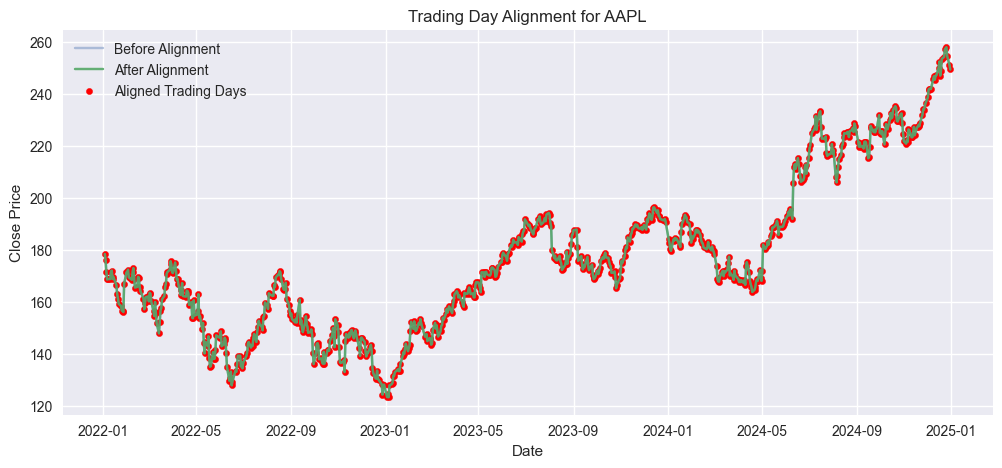

In [27]:
def plot_trading_day_alignment(df_before, df_after, ticker='AAPL'):
    before = df_before[df_before['Ticker'] == ticker]
    after = df_after[df_after['Ticker'] == ticker]

    plt.figure(figsize=(12,5))
    plt.plot(before['Date'], before['Close'], label='Before Alignment', alpha=0.4)
    plt.plot(after['Date'], after['Close'], label='After Alignment', alpha=0.9)
    plt.scatter(after['Date'], after['Close'], color='red', s=20, label='Aligned Trading Days')
    plt.title(f'Trading Day Alignment for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
aligned_data = align_with_trading_days(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])
plot_trading_day_alignment(cleaned_data, aligned_data, ticker='AAPL')


### **Trading Day Alignment for AAPL (2022–2025)**

**Observations:**

* The aligned (green) and original (blue) lines nearly overlap, indicating most data already matched NYSE sessions.
* Red markers show evenly spaced, valid trading days with gaps only around holidays.
* Minor shifts near late 2022 and 2023 reflect removal of non-trading days.
* Overall price trend—decline in 2022, recovery through 2023, strong rally in 2024—remains unchanged.

**Insights:**

* Alignment removes weekends/holidays, ensuring returns and volatility use real trading intervals.
* Produces uniform daily spacing for accurate time-series and rolling metrics.
* Enables cross-ticker synchronization for correlation or portfolio analysis.
* Confirms dataset integrity and that prior cleaning preserved true market structure.


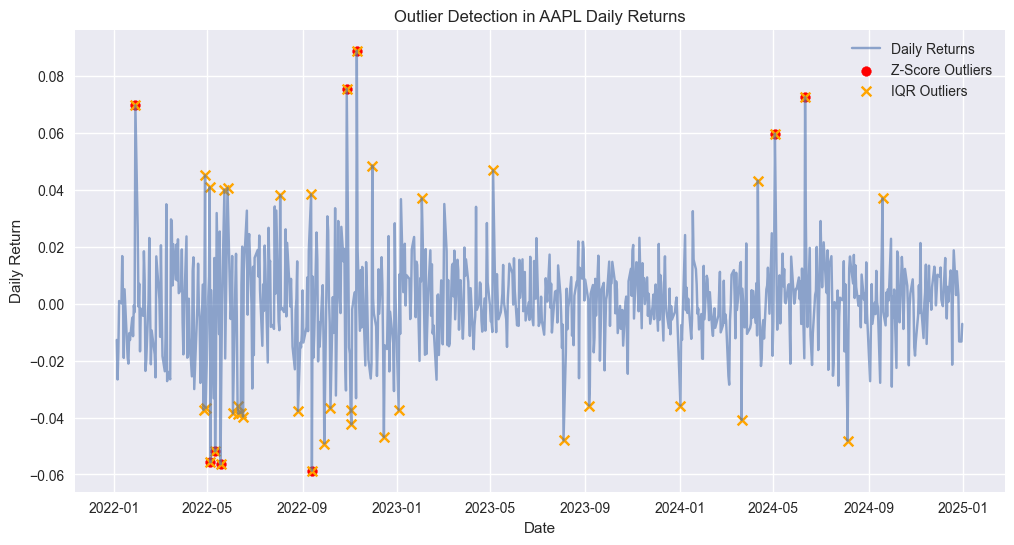

In [28]:
def plot_outliers(df: pd.DataFrame, tickers: list[str] | str):
    """
    Plot daily returns and highlight outliers for one or more tickers.
    """
    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        subset = df[df["Ticker"] == ticker]
        plt.figure(figsize=(12, 6))
        plt.plot(subset["Date"], subset["Daily_Return"], label="Daily Returns", alpha=0.6)
        plt.scatter(subset["Date"][subset["Outlier_Z"]],
                    subset["Daily_Return"][subset["Outlier_Z"]],
                    color="red", label="Z-Score Outliers")
        plt.scatter(subset["Date"][subset["Outlier_IQR"]],
                    subset["Daily_Return"][subset["Outlier_IQR"]],
                    color="orange", marker="x", label="IQR Outliers")

        plt.title(f"Outlier Detection in {ticker} Daily Returns")
        plt.xlabel("Date")
        plt.ylabel("Daily Return")
        plt.legend()
        plt.show()

# Example: Plot for all tickers in a loop
plot_outliers(cleaned_data, ["AAPL"]) 
# plot_outliers(cleaned_data, ["AAPL", "JPM"])  # Tech & Finance examples

### **Outlier Detection in AAPL Daily Returns (2022–2025)**

**Observations:**

* Most daily returns cluster around 0–2%, with occasional large spikes indicating high volatility.
* **Z-score outliers (|Z| > 3)** are few but represent extreme moves, typically during earnings or major macro events.
* **IQR outliers** occur more often, capturing moderate deviations beyond normal fluctuations.
* Noticeable volatility clusters appear in mid-2022, early 2023, and mid-2024, showing periods of sustained market turbulence.
* Both positive and negative spikes occur, though extreme swings remain rare.

**Insights:**

* Outliers identify high-risk trading days and periods of instability.
* Z-score outliers aid stress testing; IQR outliers reveal broader volatility behavior.
* Clusters of outliers highlight extended market activity phases, guiding trade timing and hedging decisions.


## 6) Data quality report & validation
This section verifies the integrity of the processed dataset through a structured **data quality report**.  

The validation checks include:
- Total row count per ticker
- Start and end dates
- Missing value percentages
- Duplicate entry counts
- Trading day coverage against expected market calendars

I also run automated validation functions to flag common issues early, such as:
- Missing critical columns
- Gaps in trading dates
- Negative or invalid price entries

> **Why**: A formal validation step provides confidence that the data is reliable before deeper analysis or visualization. It’s also useful for debugging if anything breaks later in the pipeline.


In [29]:
# 6. Data Quality & Validation

def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a data quality report per ticker including:
        - Row count
        - Date range
        - Missing values %
        - Duplicate dates
        - Coverage of expected NYSE trading days
    """
    core_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    report = []
    nyse = mcal.get_calendar('NYSE')  # NYSE trading calendar

    # Group by ticker and calculate metrics
    for ticker, group in df.groupby('Ticker'):
        total_rows = len(group)
        
        # Missing values %
        missing_pct = (group[core_cols].isnull().sum().sum() / (total_rows * len(core_cols))) * 100
        
        # Duplicate date count
        duplicates = group.duplicated(subset=['Date']).sum()
        
        # Date range
        min_date, max_date = group['Date'].min(), group['Date'].max()
        
        # Trading days coverage
        schedule = nyse.schedule(start_date=min_date, end_date=max_date)
        expected_days = len(schedule)
        coverage_pct = (total_rows / expected_days) * 100 if expected_days > 0 else np.nan
        
        # Append metrics to report
        report.append({
            'Ticker': ticker,
            'Rows': total_rows,
            'Date Range': f'{min_date.date()} → {max_date.date()}',
            'Missing %': f'{missing_pct:.2f}%',
            'Duplicates': duplicates,
            'Coverage %': f'{coverage_pct:.2f}%'
        })
    
    return pd.DataFrame(report)

# Example usage (after cleaning and outlier detection)
report = data_quality_report(cleaned_data)
print("Data Quality Report")
display(report)  # Display summary table

Data Quality Report


,Ticker,Rows,Date Range,Missing %,Duplicates,Coverage %
0,AAPL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
1,GOOGL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
2,JPM,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
3,MSFT,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
4,TSLA,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%


In [30]:
# 9. Validation Tests
def validate_preprocessing(df: pd.DataFrame, start_date: str, end_date: str):
    """
    Perform automated checks to ensure preprocessing correctness:
        1. No missing core values
        2. Daily returns computed correctly
        3. Non-negative prices
        4. No duplicate dates
        5. Date ranges within bounds
    """
    # 1. Missing values
    assert df[["Open", "High", "Low", "Close", "Volume"]].isnull().sum().sum() == 0, \
        "Missing values remain!"

    # 2. Daily returns consistency
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        expected_returns = subset["Close"].pct_change()
        assert np.allclose(subset["Daily_Return"].dropna(), expected_returns.dropna(), equal_nan=True), \
            f"Daily returns mismatch for {ticker}"

    # 3. Non-negative prices
    assert (df[["Open", "High", "Low", "Close"]] >= 0).all().all(), "Negative prices detected!"

    # 4. No duplicates
    for ticker, group in df.groupby("Ticker"):
        assert not group["Date"].duplicated().any(), f"Duplicates found in {ticker}"

    # 5. Date range validation
    for ticker, group in df.groupby("Ticker"):
        assert group['Date'].min() >= pd.to_datetime(start_date), f'Start date invalid for {ticker}'
        assert group['Date'].max() <= pd.to_datetime(end_date), f'End date invalid for {ticker}'

    print("Preprocessing validations passed!")


# Run validation checks
validate_preprocessing(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])

Preprocessing validations passed!


## 7) Pivot to wide format & basic statistics
After cleaning and validation, the data is reshaped from **long format** (Date + Ticker) to **wide format** (Date × Ticker).  
This structure makes time series calculations and visualizations more efficient, especially for cross-ticker comparisons.

Additionally, I compute basic descriptive statistics for each ticker:
- Mean and standard deviation of returns
- Volatility measures
- Skewness and kurtosis
- Simple Sharpe ratio approximation

> **Why**: Pivoting simplifies multi-ticker analysis and makes statistical computations more intuitive. The descriptive stats provide a first look at how different assets behave and how risky or stable they are.



In [31]:
def pivot_wide(df):
    pivot = df.pivot(index='Date', columns='Ticker', values='Close').ffill().bfill()
    return pivot

def compute_stats(pivot):
    daily_returns = pivot.pct_change().dropna()
    stats_df = pd.DataFrame({
        'Ticker': daily_returns.columns,
        'Mean Return': daily_returns.mean(),
        'Volatility (Std)': daily_returns.std(),
        'Min Return': daily_returns.min(),
        'Max Return': daily_returns.max(),
        'Skewness': daily_returns.skew(),
        'Kurtosis': daily_returns.kurtosis(),
        'Sharpe (approx)': daily_returns.mean()/daily_returns.std()
    }).reset_index(drop=True)
    return stats_df

# Example usage:
pivot = pivot_wide(cleaned_data)
stats_df = compute_stats(pivot)
stats_df

,Ticker,Mean Return,Volatility (Std),Min Return,Max Return,Skewness,Kurtosis,Sharpe (approx)
0,AAPL,0.000591,0.017067,-0.058680,0.088975,0.213378,2.514842,0.034635
1,GOOGL,0.000572,0.020627,-0.095094,0.102244,0.013493,2.727517,0.027731
2,JPM,0.000759,0.015743,-0.064678,0.115445,0.398059,5.741147,0.048196
3,MSFT,0.000491,0.017372,-0.077156,0.082268,0.009359,1.955808,0.028278
4,TSLA,0.000755,0.038618,-0.123346,0.219190,0.245814,2.193303,0.019547


## 8) Visualizations (presentation-ready)
This section transforms analytical outputs into clear and **interactive visualizations**.  
I use Plotly and Streamlit in other modules, but here I generate static and interactive plots for exploratory analysis.

Key visualization components:
- **SMA Chart**: Shows moving averages and potential signal points
- **Buy/Sell Indicator Plot**: Highlights where signals would have triggered trades
- **Streak Plot**: Visualizes sequences of consecutive gains or losses
- **Profit Comparison Chart**: Contrasts performance of different tickers
- **Risk vs Return Scatterplot**: Places each stock on a risk-return map

> **Why**: Visualizing market patterns helps identify trends, volatility clusters, and strategy performance more intuitively than tables or raw numbers.



In [32]:
from src.graph import (plot_price_sma,plot_streaks,plot_profit_comparison,plot_annual_risk_return,plot_best_buy_sell)  # 
from src.profit import calculate_profits
from src.analytics import calculate_annual_risk_return

# 1) Prepare data
ticker = "AAPL"  # Change as needed
subset = cleaned_data[cleaned_data["Ticker"] == ticker].sort_values("Date").copy()

# Calculate Daily Returns if not already present
if "Daily_Return" not in cleaned_data.columns:
    cleaned_data["Daily_Return"] = cleaned_data.groupby("Ticker")["Close"].pct_change()

# Calculate Streaks if not already present
if "Streak" not in cleaned_data.columns:
    def compute_streaks(group):
        streak = []
        current_streak = 0
        for r in group["Daily_Return"].fillna(0):
            if r > 0:
                current_streak = current_streak + 1 if current_streak > 0 else 1
            elif r < 0:
                current_streak = current_streak - 1 if current_streak < 0 else -1
            else:
                current_streak = 0
            streak.append(current_streak)
        group["Streak"] = streak
        return group

    cleaned_data = cleaned_data.groupby("Ticker").apply(compute_streaks).reset_index(drop=True)


In [33]:
# 2) SMA + Buy/Sell Crossovers
print(f"\n📈 SMA Price Chart + Crossovers for {ticker}")
sma_windows = [10]  # can add more
plot_price_sma(cleaned_data, ticker=ticker, sma_windows=sma_windows)

2025-10-11 06:10:10.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.101 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



📈 SMA Price Chart + Crossovers for AAPL


#### Exploratory Data Analysis: AAPL Price + SMA Crossovers (2022–2025) ####
The chart above displays Apple’s (AAPL) daily closing price (blue line) and its 10-day Simple Moving Average (SMA 10, orange dashed line) from early 2022 through early 2025. Buy signals (green triangles) mark points where the price crosses above the SMA, and Sell signals (red triangles) indicate price crossing below the SMA.

### Observations
-  Frequent Crossovers: The chart features frequent buy and sell signals, reflecting AAPL’s active movement around its short-term SMA. These crossovers cluster during periods of heightened volatility or when the price trend sharply changes.
- Trend Phases: During sustained upward trends (such as mid-2024 to early 2025), buy signals tend to initiate long price rallies with fewer intervening sell signals. Conversely, during sideways or choppy periods (notably mid-2022 to early 2023), there is a rapid alternation between signals due to short-lived price swings.

### Insights
- The visual pattern and signal clustering in the chart help evaluate when SMA-based trading is more effective (trending periods) versus when it might lead to overtrading (sideways markets). Reviewing these patterns helps refine the timing or parameters (e.g., length of SMA) to match current market behavior and an investor’s tolerance for risk and activity.

In [34]:
# 3) Buy / Sell Signal Graph
print(f"\n🟢🔴 Buy / Sell Points for {ticker}")
plot_best_buy_sell(cleaned_data, ticker=ticker)



🟢🔴 Buy / Sell Points for AAPL


2025-10-11 06:10:10.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.180 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


#### Exploratory Data Analysis: AAPL Optimal Buy/Sell Points (2022–2025) ####
This chart presents Apple's (AAPL) closing price (blue line) and optimal Buy (green triangle) and Sell (red triangle) points from January 2022 to January 2025. 

### Observations
- Active Trading: Buy and Sell signals appear frequently throughout the period, reflecting an approach that responds rapidly to price and trend fluctuations. Signals are tightly clustered during choppy phases (e.g., early 2022 and much of 2023) when price moves are short-lived and reversal-prone.
- Downtrend Periods: In the first half of 2022, Sell signals dominate as price trends downward, with only a few short-lived Buy signals. This highlights the algorithm’s ability to quickly shift to cash or defensive positioning.
- Uptrend Recovery: Starting from mid-2023, Buy signals become more frequent and follow clear upward price movements. The extended rally into late 2024 and early 2025 features more grouped Buy signals and less frequent Sells, showing the approach’s shift towards longer holding periods as the price climbs.
- Signal Clustering: Clusters of signals align with volatile phases and price consolidation; relative sparsity in trending periods (late 2024) reflects fewer changes in trend direction and less trading activity.

### Insights
- More Buy signals, along with fewer Sell signals, during the extended uptrend in 2024 suggest improved returns for trend-following strategies during these phases.

In [35]:
# 4) Streak Graph
print(f"\n📊 Streak Chart for {ticker}")
plot_streaks(cleaned_data, ticker=ticker)


📊 Streak Chart for AAPL


2025-10-11 06:10:10.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.339 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


#### Exploratory Data Analysis: AAPL Upward and Downward Trends (2022–2025)
This chart displays Apple's (AAPL) closing price from early 2022 through late 2025, with trend segments highlighted in color: green for upward trends and red for downward trends. The overlay allows for easy identification of trend changes and the behavior of price momentum over time.

### Observations
- Alternating Trends: The price series features regular alternation between upward (green) and downward (red) segments, especially during the choppy periods of 2022 and early 2023.
- Sustained Downtrend: Early 2022 to late 2022 is marked by frequent red (downward) stretches, reflecting a period of overall price decline and volatility with only occasional brief green rallies.
- Recovery and Growth: From late 2022 through 2023, green segments increase in duration, showing a persistent recovery and transition into an uptrend. The period from early 2024 onward is dominated by longer, uninterrupted upward trends, sharply pushing price higher.

### Insights
- Visual Trend Mapping: Segment-based coloring helps quickly locate areas of persistent uptrend (buying opportunities) versus extended declines (riskier or more defensive phases).
- Strategic Implications: Investors can use this type of trend visualization to better time entries and exits, align with prevailing direction, and avoid overtrading in noisy markets. Recognizing longer trend durations can assist with holding through volatility, while frequent switches may call for tighter risk control.

In [36]:
# 5) Profit Comparison Graph
print(f"\n💰 Profit Comparison")
profits_df = calculate_profits(cleaned_data)
plot_profit_comparison(profits_df)

INFO:src.profit:AAPL → Buy: 2023-01-05 @ $123.28, Sell: 2024-12-26 @ $258.10, Profit: $134.82, Return: 109.36%, MultiTx: $835.20
INFO:src.profit:MSFT → Buy: 2022-11-03 @ $209.05, Sell: 2024-07-05 @ $463.24, Profit: $254.19, Return: 121.59%, MultiTx: $1558.00
INFO:src.profit:GOOGL → Buy: 2022-11-03 @ $82.86, Sell: 2024-12-16 @ $196.02, Profit: $113.16, Return: 136.57%, MultiTx: $750.83
INFO:src.profit:JPM → Buy: 2022-10-11 @ $94.69, Sell: 2024-11-25 @ $245.10, Profit: $150.41, Return: 158.83%, MultiTx: $656.23
INFO:src.profit:TSLA → Buy: 2023-01-03 @ $108.10, Sell: 2024-12-17 @ $479.86, Profit: $371.76, Return: 343.90%, MultiTx: $2552.41
INFO:src.profit:Profit optimization completed for all tickers.

2025-10-11 06:10:10.447 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



💰 Profit Comparison


2025-10-11 06:10:10.449 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.450 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.451 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


#### Exploratory Data Analysis: Profit Comparison (Single vs Multiple Transactions, 2022–2025) ####
The bar chart compares total profits for five stocks—TSLA, MSFT, AAPL, GOOGL, and JPM, using two trading strategies: a single buy-and-hold transaction (blue bars) versus multiple timed transactions (orange bars) over the period 2022 to 2025.

### Observations
- Consistent Outperformance: For every stock, the multiple transaction strategy yields considerably higher profit than the single transaction. This indicates effective timing and capturing of trends via multiple buys and sells.
- TSLA Dominates: TSLA stands out with the highest profits for both strategies. In particular, multiple transactions on TSLA produce a dramatic gain (over 2500), far exceeding all other tickers and dwarfing the single-transaction result for TSLA (about 372).
- Scaling Effect: Profits for MSFT, AAPL, GOOGL, and JPM all follow the same trend: multiple transactions reward with two to six times greater profit than a buy-and-hold approach. For MSFT, multiple transactions generate roughly 1558 compared to 254 for a single transaction; for AAPL, 835 compared to 135; for GOOGL, 751 compared to 113; and for JPM, 656 compared to 150.

### Insights
- Benefit of Active Trading: Systematically trading in and out of positions enables the capture of more upswings and avoidance of downturns, significantly boosting returns versus simply holding the stock.
- Higher Volatility Stocks: The gap between strategies is most pronounced in volatile stocks like TSLA, where price swings create more opportunities for effective trading signals.
- Practical Application: While multiple transactions increase profit potential, they may come with added transaction costs and require strict discipline or automation. The chart underscores the importance of strategy choice for optimizing returns depending on market style and risk tolerance.


In [37]:
# 6) Risk vs Return Graph
print(f"\n📉 Risk vs Return")
risk_return_df = calculate_annual_risk_return(cleaned_data)
plot_annual_risk_return(risk_return_df)

INFO:src.analytics:Annual risk-return calculated.
2025-10-11 06:10:10.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-11 06:10:10.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.



📉 Risk vs Return


#### Exploratory Data Analysis: Annualized Risk vs Return with Sharpe Highlight (2022–2025) ####
The scatter plot above presents annualized risk (volatility) on the x-axis and annualized return on the y-axis for five stocks: AAPL, GOOGL, JPM, MSFT, and TSLA. Each point represents a stock, with a special red star marking the stock with the highest Sharpe ratio ("Best Sharpe").

### Observations
- TSLA (Tesla) appears on the far right and higher up, exhibiting both the highest annualized risk and a strong return. This places it as the most volatile and most lucrative asset in the group, but also the riskiest.
- JPM (JPMorgan Chase), highlighted with a red star, has the highest Sharpe ratio—meaning that, relative to its risk, it delivers the best risk-adjusted return. JPM achieves this by combining a comparatively high return with the lowest risk among the group.
- AAPL (Apple) sits in the mid-range for both risk and return, slightly outperforming both MSFT (Microsoft) and GOOGL (Google), which also cluster around moderate risk and moderate return values.
- The distribution shows a clear tradeoff between risk and return: higher returns generally accompany higher risk (TSLA), while stocks like JPM achieve more efficient (risk-adjusted) performance.

### Insights
- Sharpe Ratio Usefulness: The visual Sharpe highlight allows quick identification of the most efficient stock—not just in terms of return, but factoring in the risk taken to achieve those returns. Investors looking for strong risk-adjusted results may favor JPM over TSLA, despite TSLA's higher absolute return.
- Visual Mapping: Highlighting the "Best Sharpe" stock offers a direct visual cue, helping cut through raw numbers to easily see which asset delivers the most favorable blend of risk and reward over the observed period.

## 9) Save cleaned & pivot datasets
In this section, I save both:
- **Long format dataset** (cleaned and validated)
- **Wide format dataset** (pivoted for analysis)

These files are stored in the `data/` directory.  
This structure allows other modules (e.g., analytics, dashboards, or machine learning pipelines) to reuse the processed data directly without repeating preprocessing steps.

> **Why**: Saving outputs improves reproducibility and efficiency, making the workflow modular and production-friendly.


In [38]:
# Save (uncomment to write)
def save_outputs(cleaned_df, pivot_df, config):
    os.makedirs(os.path.dirname(config['output_long']), exist_ok=True)
    os.makedirs(os.path.dirname(config['output_wide']), exist_ok=True)
    
    # Save long-format dataset
    cleaned_df.to_csv(config['output_long'], index=False)
    print(f"Long-format dataset saved: {config['output_long']}")
    
    # Save wide-format dataset
    pivot_df.to_csv(config['output_wide'])
    print(f"Wide-format dataset saved: {config['output_wide']}")

# Example usage:
save_outputs(cleaned_data, pivot, CONFIG)


Long-format dataset saved: data/cleaned_stock_data_long.csv
Wide-format dataset saved: data/cleaned_stock_data_wide.csv
